# Top skills required for Data Scientist jobs

For this project, I have web scraped job postings from Indeed website in order to determine which skills are in-demand for data scientist jobs.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
import re
import csv
import os
import bs4
from bs4 import BeautifulSoup
import time
import warnings
warnings.simplefilter("ignore")

In [3]:
# Extract data from Indeed website

def extract_job_desc(url):
    time.sleep(0.5)
    try:
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'lxml')
        job_desc = soup.find('div', attrs={'id': 'jobDescriptionText'})
        return job_desc.text.strip()
    except:
        return "No job description"


#This was set to the 3 exp levels.
exp_lev = ['entry_level' , 'mid_level', 'senior_level']
columns = ["Page Num", "link", "Experience", "job_title", "company_name", "salary"]
df_data_scientist = pd.DataFrame(columns = columns)
#This was set to 500
last_page = 500
for exp in exp_lev:
  for start in range(0, last_page, 10):
    url = 'https://www.indeed.com/jobs?q=data+scientist&explvl=' + str(exp) + '&start='+ str(start)
    page = requests.get(url)     
    soup = BeautifulSoup(page.text, "lxml", from_encoding="utf-8")
    for div in soup.find_all(name="div", attrs={"class":"row"}):
      sponsered = div.find_all(name="span", attrs={"class":" sponsoredGray "}) 
      if len(sponsered) == 0:
        num = (len(df_data_scientist) + 1)
                
        #creating an empty list to hold the data for each posting
        job_post = []

        #Page num
        job_post.append(str(start))

        #Link
        for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
          try:
            link = 'https://www.indeed.com'+ a['href']
            job_post.append(link)
          except:
            link = "None"
            job_post.append(link)

        #experience Level
        job_post.append(exp)

        #job title
        for title in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
          job_post.append(title["title"])

        # company name
        company = div.find_all(name="span", attrs={"class":"company"}) 
        if len(company) > 0:
          for name in company:
            job_post.append(name.text.strip()) 
        else:
          sec_try = div.find_all(name="span", attrs={"class":"result-link-source"})
          for span in sec_try:
            job_post.append(span.text)
            if len(sec_try) == 0:
              job_post.append("None")  
            
        # salary
        salary = div.find_all(name='span', attrs={"class":"salaryText"})
        if len(salary) > 0:
          for span in salary:
            job_post.append(span.text.strip())
        else:
          job_post.append("No salary listed")

        df_data_scientist.loc[num] = job_post

In [4]:
# Show first 10 results
df_data_scientist.head(10)

,Page Num,link,Experience,job_title,company_name,salary
1,0,https://www.indeed.com/rc/clk?jk=3dde013381898...,entry_level,Data Scientist - Entry Level,Numerdox,No salary listed
2,0,https://www.indeed.com/rc/clk?jk=44131ed251933...,entry_level,Data Classification Specialist - Contract,Idiomatic,$20 an hour
3,0,https://www.indeed.com/rc/clk?jk=eabd8f9b8389e...,entry_level,Data Scientist Summer Intern: 2021,IBM,No salary listed
4,0,https://www.indeed.com/rc/clk?jk=a12209822929b...,entry_level,Vitria Data Scientist,Vitria Technology,No salary listed
5,0,https://www.indeed.com/company/Revenue-Managem...,entry_level,Data Scientist - Entry Level,Revenue Management Solutions,"$65,000 - $75,000 a year"
6,0,https://www.indeed.com/company/ForMotiv/jobs/D...,entry_level,Data Scientist,ForMotiv,"$75,000 - $120,000 a year"
7,0,https://www.indeed.com/rc/clk?jk=eb631f1018954...,entry_level,Enterprise Data Scientist I,Farmers Insurance Group,No salary listed
8,0,https://www.indeed.com/company/Neal-Analytics/...,entry_level,Data Scientist (REMOTE),Neal Analytics,$50 - $60 an hour
9,0,https://www.indeed.com/rc/clk?jk=d142a6e8cf91b...,entry_level,Climate Data Scientist,McKinsey & Company,No salary listed
10,0,https://www.indeed.com/rc/clk?jk=0d61f1b54a9f2...,entry_level,Cascade Data Labs - Data Analyst/Data Scientis...,Kin + Carta,"$65,000 - $160,000 a year"


In [6]:
# List possible skill requirements
technical_skill = ['excel', 'python', 'r', 'java', 'c', 'c++', 'matlab', 'sas','sql', 
                   'tableau', 'hadoop', 'spark','power bi',
                   'tensorflow', 'keras','pytorch','theano','caffe', 
                   'machine learning', 'data science', 'analytics', 'data visualization', 
                   'stata', 'ruby', 'perl', 'javascript']
business_skill = ['communication', 'problem solving', 'project management', 'consulting', 
                  'presentation', 'leadership', 'documentation', 'marketing', 
                  'time management', 'collaborate', 'organize', 'powerpoint', 'teamwork']
skills = technical_skill + business_skill 
# Add columns for skills
for skill in skills:
  df_data_scientist[skill] = np.zeros(len(df_data_scientist))

df_data_scientist = df_data_scientist.reset_index()
df_data_scientist.head()

,index,Page Num,link,Experience,job_title,company_name,salary,excel,python,r,java,c,c++,matlab,sas,sql,tableau,hadoop,spark,power bi,tensorflow,keras,pytorch,theano,caffe,machine learning,data science,analytics,data visualization,stata,ruby,perl,javascript,communication,problem solving,project management,consulting,presentation,leadership,documentation,marketing,time management,collaborate,organize,powerpoint,teamwork
0,1,0,https://www.indeed.com/rc/clk?jk=3dde013381898...,entry_level,Data Scientist - Entry Level,Numerdox,No salary listed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,https://www.indeed.com/rc/clk?jk=44131ed251933...,entry_level,Data Classification Specialist - Contract,Idiomatic,$20 an hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,https://www.indeed.com/rc/clk?jk=eabd8f9b8389e...,entry_level,Data Scientist Summer Intern: 2021,IBM,No salary listed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,https://www.indeed.com/rc/clk?jk=a12209822929b...,entry_level,Vitria Data Scientist,Vitria Technology,No salary listed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,https://www.indeed.com/company/Revenue-Managem...,entry_level,Data Scientist - Entry Level,Revenue Management Solutions,"$65,000 - $75,000 a year",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Confirm that column 2 is the column for job detail link
df_data_scientist.iloc[1,2]

'https://www.indeed.com/rc/clk?jk=44131ed25193370d&fccid=5e623a7a509ae315&vjs=3'

In [8]:
# For each job, check its job details/description page
# to collect the required skills.
# Set skill entries to 1 if they are mentioned in job details


for i in range(len(df_data_scientist)):
  link = requests.get(df_data_scientist.iloc[i,2])
  soup = BeautifulSoup(link.text, "lxml")
  try:
    text = soup.find('div', class_ = 'jobsearch-jobDescriptionText').text.strip().lower()
    # Preprocessing, replace punctuations, and replace multiple spaces
    text = re.sub(r'\,', ' ', text) 
    text = re.sub('/', ' ', text) 
    text = re.sub(r'\(', ' ', text) 
    text = re.sub(r'\)', ' ', text) 
    text = re.sub(' +',' ',text) 
  except:
    text = ""

  for s in skills :
    # This is specifically for C++, escape the ++. Convert C++ to C\+\+
    if any(x in s for x in ['+']):
      skill = re.escape(s)
    else:
      skill = s
    matching = re.search(r'(?:^|(?<=\s))' + skill + r'(?=\s|$)',text)
    if matching:
      df_data_scientist[s][i] = 1
      #print("matched skill ",s, "for job ",str(i+1))

In [9]:
df_data_scientist.head(10)

,index,Page Num,link,Experience,job_title,company_name,salary,excel,python,r,java,c,c++,matlab,sas,sql,tableau,hadoop,spark,power bi,tensorflow,keras,pytorch,theano,caffe,machine learning,data science,analytics,data visualization,stata,ruby,perl,javascript,communication,problem solving,project management,consulting,presentation,leadership,documentation,marketing,time management,collaborate,organize,powerpoint,teamwork
0,1,0,https://www.indeed.com/rc/clk?jk=3dde013381898...,entry_level,Data Scientist - Entry Level,Numerdox,No salary listed,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,https://www.indeed.com/rc/clk?jk=44131ed251933...,entry_level,Data Classification Specialist - Contract,Idiomatic,$20 an hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,https://www.indeed.com/rc/clk?jk=eabd8f9b8389e...,entry_level,Data Scientist Summer Intern: 2021,IBM,No salary listed,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0,https://www.indeed.com/rc/clk?jk=a12209822929b...,entry_level,Vitria Data Scientist,Vitria Technology,No salary listed,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,0,https://www.indeed.com/company/Revenue-Managem...,entry_level,Data Scientist - Entry Level,Revenue Management Solutions,"$65,000 - $75,000 a year",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,0,https://www.indeed.com/company/ForMotiv/jobs/D...,entry_level,Data Scientist,ForMotiv,"$75,000 - $120,000 a year",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,0,https://www.indeed.com/rc/clk?jk=eb631f1018954...,entry_level,Enterprise Data Scientist I,Farmers Insurance Group,No salary listed,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,0,https://www.indeed.com/company/Neal-Analytics/...,entry_level,Data Scientist (REMOTE),Neal Analytics,$50 - $60 an hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,0,https://www.indeed.com/rc/clk?jk=d142a6e8cf91b...,entry_level,Climate Data Scientist,McKinsey & Company,No salary listed,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,0,https://www.indeed.com/rc/clk?jk=0d61f1b54a9f2...,entry_level,Cascade Data Labs - Data Analyst/Data Scientis...,Kin + Carta,"$65,000 - $160,000 a year",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [15]:
# Display the shape of the table.
df_data_scientist.shape

(2234, 46)

In [10]:
import matplotlib.pyplot as plt
df_tech = df_data_scientist[technical_skill]
tech_count = df_tech.sum()
tech_count = tech_count.sort_values(ascending=False)
df_tcount = pd.DataFrame(data=tech_count,columns=["Count"])
df_tcount.index.name = "Technical Skills"
df_tcount
#plt.bar(,tech_count.to_list)

,Count
Technical Skills,
python,190.0
machine learning,182.0
data science,160.0
r,128.0
analytics,127.0
sql,107.0
data visualization,46.0
tableau,40.0
spark,38.0


## Technical Skills Required for Data Scientist Jobs

Text(0.5, 1.0, 'Technical Skills Required for Data Scientist Jobs on Indeed.ca')

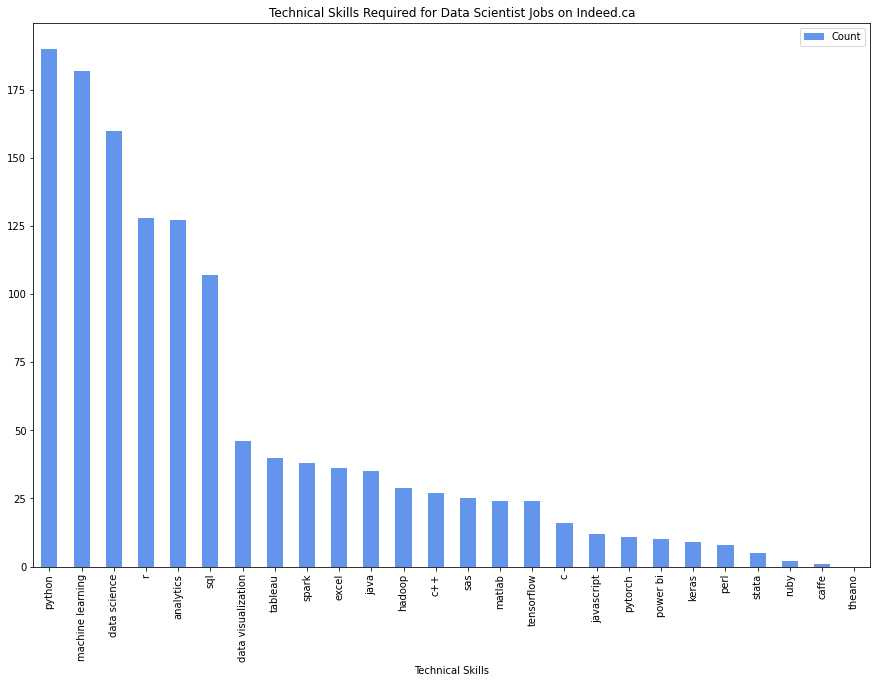

In [11]:
df_tcount.plot(kind="bar", figsize=(15,10), color='cornflowerblue')
plt.title('Technical Skills Required for Data Scientist Jobs on Indeed.ca')

In [13]:
df_bus = df_data_scientist[business_skill]
bus_count = df_bus.sum()
bus_count = bus_count.sort_values(ascending=False)
df_bcount = pd.DataFrame(data=bus_count,columns=["Count"])
df_bcount.index.name = "Business Skills"
df_bcount
#plt.bar(,tech_count.to_list)

,Count
Business Skills,
communication,112.0
collaborate,50.0
marketing,37.0
leadership,35.0
presentation,32.0
problem solving,22.0
consulting,17.0
documentation,13.0
teamwork,12.0


## Business Skills Required for Data Scientist Jobs

Text(0.5, 1.0, 'Business Skills Required for Data Scientist Jobs on Indeed.ca')

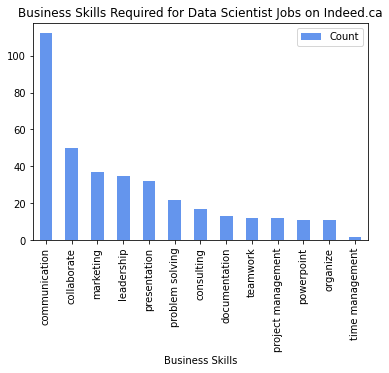

In [14]:
df_bcount.plot(kind="bar", color='cornflowerblue')
plt.title('Business Skills Required for Data Scientist Jobs on Indeed.ca')